# Applied Deep Learning Tutorial 
contact: Mark.schutera@kit.edu


# Deep Reinforcement Learning with Deep-Q-Network (DQN)

## Introduction
In this tutorial, you will attempt to implement a Deep-Q-Network that is able to do a classic control. The approaches are build upon the paper by DeepMind: Playing Atari with Deep Reinforcement Learning [paper](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), which first introduces the notion of a Deep Q-Network.
<img src="graphics/atari_play.png" width="700"><br>
<center> Fig. 1: Breakout environment of the Atari game </center>

## Core idea
As you probably remember from the lecture, during trial and error we can learn a policy for our Atari game, and model it within our Q-matrix. This is done with a deep neural network. After training, this Q-matrix gives us an estimate of the expected reward when taking action a in state s: Q(s, a).
Playing the action with the maximum Q-value in any given state is the same as playing optimal, or following a full exploitation strategy.

## OpenAI Gym
[OpenAI Gym](https://gym.openai.com/docs/) is a library that can simulate a large number of reinforcement learning environments, including Atari games (these need to be installed additionaly). You will need Python 3.5+

>pip install gym


## Taking our cart pole on a first ride
Now that you have gym installed you can load the 'Pendulum-v0' environment of Atari.


In [11]:
# Import the gym module
import gym


In [3]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()


/Users/julia/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
# Load the environment
env = gym.make('Pendulum-v0')

# Reset, it returns the starting frame
frame = env.reset()

for _ in range(100000):
    # Perform a random action, returns the new frame, reward and whether the game is over
    
    '''
    Implement to sample a random action from the action space within the loaded environment
    action = environment.action_space.sample()
    '''
    action = env.action_space.sample()
    observation, reward, is_done, info = env.step(action)
    print('observation: ', observation, 'reward: ', reward)
    print('info :', info)
    if is_done: break
    env.render()

env.close()


observation:  [0.72955971 0.68391712 0.94314556] reward:  -0.5524424287818741
info : {}
observation:  [0.67451738 0.73825897 1.5473434 ] reward:  -0.6565097947031091
info : {}
observation:  [0.58660757 0.80987133 2.26894363] reward:  -0.9303864001841887
info : {}
observation:  [0.46520848 0.88520115 2.85986969] reward:  -1.4058315795311234
info : {}
observation:  [0.30465916 0.95246144 3.48579116] reward:  -1.9993581619819545
info : {}
observation:  [0.0980243  0.99518402 4.22797186] reward:  -2.8057736583315505
info : {}
observation:  [-0.137063    0.99056233  4.71355569] reward:  -3.9591907279600282
info : {}
observation:  [-0.39123981  0.92028876  5.28965166] reward:  -5.141259718801684
info : {}
observation:  [-0.64395985  0.76505928  5.9536907 ] reward:  -6.6899120652827175
info : {}
observation:  [-0.86149174  0.50777159  6.77074532] reward:  -8.702258592450818
info : {}
observation:  [-0.98285941  0.18435664  6.94357755] reward:  -11.393084897150466
info : {}
observation:  [-0.9

observation:  [ 0.23387906  0.9722657  -5.05313783] reward:  -5.883980784739645
info : {}
observation:  [ 0.43072202  0.90248465 -4.18454319] reward:  -4.335790178247671
info : {}
observation:  [ 0.57935974  0.81507196 -3.45300573] reward:  -3.017931533833724
info : {}
observation:  [ 0.69491096  0.71909579 -3.00706265] reward:  -2.1014697280886927
info : {}
observation:  [ 0.76889117  0.63937968 -2.17618068] reward:  -1.5520273341171358
info : {}
observation:  [ 0.82771006  0.56115601 -1.95818892] reward:  -0.9578239517646796
info : {}
observation:  [ 0.86664556  0.49892431 -1.46849304] reward:  -0.7386168532312616
info : {}
observation:  [ 0.89103662  0.45393142 -1.02369051] reward:  -0.48872572710118267
info : {}
observation:  [ 0.91178653  0.4106645  -0.95979725] reward:  -0.330197075847834
info : {}
observation:  [ 0.92402057  0.38234276 -0.61704714] reward:  -0.27125837535365543
info : {}
observation:  [ 0.92839964  0.37158324 -0.23233181] reward:  -0.19242432043552413
info : {}


In [8]:
env = gym.make('Pendulum-v0')

# Reset, it returns the starting frame
frame = env.reset()
#print('Actions:')
#print(env.action_space)
#print(env.action_space.high)
#print(env.action_space.low)
#print('Observations:')
#print(env.observation_space)
#print(env.observation_space.high)
#print(env.observation_space.low)

env.close()


This already looks nice, yet the actions are random and thus it is time to better understand our environment. And to implement our Deep-Q-Network


In [6]:
# import the necessary libraries
import gym
import gym.spaces
import gym.wrappers
import numpy as np
import random
import pickle
from collections import deque
from keras.layers import Flatten, Dense, Input
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras import optimizers

Using TensorFlow backend.


## Observation
The observation is made up of cos(theta), sin(theta) and theta dot. 
Theta is normalized between -pi and pi.

## Action
Joint effort -2.0 to +2.0
Write a function to discretize the continuous action space of the joint effort.


In [7]:
# define the action space
def create_action_bins(num_action_bins):
    '''
    Using linspace of numpy implement the action bins for the pendulum, when given the number of the action bins as argument
    actionbins = 
    numpy.linspace(start, stop, num = 50, endpoint = True, retstep = False, dtype = None) : 
    Returns number spaces evenly w.r.t interval. Similar to arange but instead of step it uses sample number.
    '''
    actionbins = np.linspace(-2.0, 2.0, num_action_bins)
    return actionbins

# depending on the action, find the according actionbin 
# discretization of the continuous action space
def find_actionbin(action, actionbins):
    idx = (np.abs(actionbins - action)).argmin()

    return idx

## Reward
The reward is defined as
> -(theta^2 + 0.1 x theta_dt^2 + 0.001 x action^2)

What is the lowest expected cost? And what is the highest cost?

-(pi^2 + 0.1 x 8^2 + 0.001 x 2^2) = -16.2736044 - lowest reward

-(0^2 + 0.1 x 0^2 + 0.001 x 0^2) = 0 - highest reward

From this reward function, what is the goal of the agent?
In essence, the goal is to remain at zero angle (vertical), with the least rotational velocity, and the least effort.

For a hint have a look at the [wiki](https://github.com/openai/gym/wiki).

## train_model() Function
Hier wird das Modell auf einem Batch in Memory gespeicherter Erfahrungen trainiert

In [8]:
def train_model(memory, gamma=0.9):
    for state, action, reward, state_new in memory:
        
        # flatten state to make it compatible to our neural network
        flat_state_new = np.reshape(state_new, [1, 3])
        flat_state = np.reshape(state, [1, 3])

        # determine estimated reward given state s' after action a, 
        # combination of observed and predicted exploited reward.
        '''
        Implement the Q-function for the flat_state_new
        target = 
        Target value is r + gamma * max[Qs in the new state] 
        '''
        target = reward + gamma * np.amax(model.predict(flat_state_new))
        # determine current expected agent rewards
        targetfull = model.predict(flat_state)
        
        # update current expected rewards with the emulated prediced reward
        targetfull[0][action] = target
        
        # Fit model based on emulation and prediction
        model.fit(flat_state, targetfull, epochs=1, verbose=0)

## Deep Q Model

As a reminder, this is our Q function.
> Q(s, a) = r + gamma max_a'(Q(s, a'))

The input of our neural network, our generalizable Q-matrix, will be the observation or the state of the pendulum. 
and the output will be the estimate of the reward taking the action a'. Gamma is the discount factor of the predicted reward in our next state. r is the reward 

For our first network we will implement a DQN with keras:

- Layer with 128 ReLU units
- Layer with 64 ReLU units
- 3 inputs and one output per action bin with linear activation function
- Adam optimizer with learning rate 0.0002, beta_1 0.9 and beta_2 0.999
- Loss mean squared error

In [9]:
# Define the Deep-Q-Network in keras

def build_model(num_output_nodes): 
    model = Sequential()  

    model.add(Dense(128, input_shape=(3,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_output_nodes, activation='linear'))
    
    model.compile(loss='mse', optimizer=optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999))

    return model

## run_episodes()-Function
Hier wird das Prinzip der "Memory Replay" umgesetzt:                
Das Gradientenabstiegsverfahren wird nicht auf den Erfahrungen nach einer einzelner Aktion ausgeführt, 
sondern auf einem Minibatch von Erfahrungen (st, at, rt, st+1). 
Dazu wird erst eine Aktion getätigt und deren Belohnung r und Folgezustand st+1 im Spiel beobachtet. 
Diese werden werden zusammen mit dem Ausgangszustand s in einer Replay-Memory gespeichert (250 Erfahrungen pro Sequence). 
An dieser Stelle wird nun kein Gradientenabstiegsverfahren mit der aktuellsten Erfahrung angestoßen (model.fit()). 
Stattdessen wird das Gradientenabstiegsverfahren auf einem Batch von 250 Erfahrungen, die in Memory gespeichert waren, durchgeführt (siehe train_model()).

In [10]:
def run_episodes(epsilon, gamma, training_iterations, sequence_iterations):
    
    # These are hyperparameters to play around with, after your first run.
    epsilon_decay = 0.9999
    epsilon_min = 0.02
    steps_per_sequence = 250

    for epoch in range(0, training_iterations // sequence_iterations):
        for sequence_id in range(0, sequence_iterations):
            state = env.reset()
            memory = deque()
            
            total_reward = 0
            
            # Easy implementation of decaying exploration

            if epsilon > epsilon_min:
                epsilon = epsilon * epsilon_decay
                
            for i in range(0, steps_per_sequence):
                
                # explore
                if np.random.uniform() < epsilon:
                    action = env.action_space.sample()
                # exploit
                else:
                    flat_state = np.reshape(state, [1, 3])
                    action = np.amax(model.predict(flat_state))

                # determine action
                actionbin = find_actionbin(action, actionbinslist)
                action = actionbinslist[actionbin]
                action = np.array([action])

                # emulate the action in the simulation and observe the transition 
                # as well as the reward
                observation, reward, done, _ = env.step(action)
                total_reward += reward

                state_new = observation

                '''
                save transitions into memory
                Hint: The memory is used as an argument for the train_model function.
                
                memory.append((_, _, _, _))
                
                '''
                memory.append((state, actionbin, reward, state_new))
                state = state_new
                
            # train model on the samples memories
            train_model(memory, gamma)
            
            print(epoch , ' epoch', sequence_id, ' sequence. Average reward = ', total_reward / steps_per_sequence, '. epsilon = ', epsilon)

           

## Function for running the policy of our DQN after loading or training


In [11]:
def play_game(rounds):
    state = env.reset()
    totalreward = 0

    for _ in range(0, rounds):
        # Rendering for visualization
        env.render()

        flat_state = np.reshape(state, [1, 3])
        actionbin = np.argmax(model.predict(flat_state))

        action = actionbinslist[actionbin]
        #print(action)
        action = np.array([action])
        
        observation, reward, done, _ = env.step(action)

        totalreward += reward

        state_new = observation
        state = state_new
        
    return totalreward

## Train the DQN


In [91]:
env = gym.make('Pendulum-v0')

# These are hyperparameters to play around with

# iterations
training_iterations = 1000
sequence_iterations = 25

# epsilon (setting exploitation vs exploration)
epsilon = 1

# gamma (importance of predicted estimated reward)
gamma = 0.9

# Discretization settings for the action space
num_action_bins = 40
actionbinslist = create_action_bins(num_action_bins)



# Build model
model = build_model(num_action_bins)

run_episodes(epsilon, gamma, training_iterations, sequence_iterations)

'''
training takes super long, this is not efficient at all, how can we bypass this?
Hint: See cells in run pretrained model.

'''
   

0  epoch 0  sequence. Average reward =  -6.977471208280163 . epsilon =  0.9999
0  epoch 1  sequence. Average reward =  -5.653621976237476 . epsilon =  0.9998000100000001
0  epoch 2  sequence. Average reward =  -4.84072767854339 . epsilon =  0.9997000299990001
0  epoch 3  sequence. Average reward =  -4.824327027086468 . epsilon =  0.9996000599960002
0  epoch 4  sequence. Average reward =  -8.60759402263013 . epsilon =  0.9995000999900007
0  epoch 5  sequence. Average reward =  -6.100504849267558 . epsilon =  0.9994001499800017
0  epoch 6  sequence. Average reward =  -6.082940472179801 . epsilon =  0.9993002099650037
0  epoch 7  sequence. Average reward =  -4.8540300082823915 . epsilon =  0.9992002799440072
0  epoch 8  sequence. Average reward =  -8.200375797151672 . epsilon =  0.9991003599160128
0  epoch 9  sequence. Average reward =  -4.032207818563496 . epsilon =  0.9990004498800211
0  epoch 10  sequence. Average reward =  -7.99281440524208 . epsilon =  0.9989005498350332
0  epoch 11 

3  epoch 15  sequence. Average reward =  -5.622385402088846 . epsilon =  0.9909408287818039
3  epoch 16  sequence. Average reward =  -4.090806070826481 . epsilon =  0.9908417346989258
3  epoch 17  sequence. Average reward =  -6.620809545147982 . epsilon =  0.9907426505254558
3  epoch 18  sequence. Average reward =  -7.438154011000577 . epsilon =  0.9906435762604033
3  epoch 19  sequence. Average reward =  -6.586421070756018 . epsilon =  0.9905445119027773
3  epoch 20  sequence. Average reward =  -7.631979756931973 . epsilon =  0.990445457451587
3  epoch 21  sequence. Average reward =  -5.140821141158852 . epsilon =  0.9903464129058418
3  epoch 22  sequence. Average reward =  -5.870478710819987 . epsilon =  0.9902473782645512
3  epoch 23  sequence. Average reward =  -4.993392483988009 . epsilon =  0.9901483535267248
3  epoch 24  sequence. Average reward =  -8.489936403083345 . epsilon =  0.9900493386913721
4  epoch 0  sequence. Average reward =  -7.850621320078804 . epsilon =  0.9899503

7  epoch 5  sequence. Average reward =  -7.357128543559145 . epsilon =  0.982061932340002
7  epoch 6  sequence. Average reward =  -6.559870826705257 . epsilon =  0.9819637261467681
7  epoch 7  sequence. Average reward =  -4.6812384040046915 . epsilon =  0.9818655297741534
7  epoch 8  sequence. Average reward =  -5.051702032808777 . epsilon =  0.981767343221176
7  epoch 9  sequence. Average reward =  -7.432997047390262 . epsilon =  0.9816691664868539
7  epoch 10  sequence. Average reward =  -6.0802162489842875 . epsilon =  0.9815709995702052
7  epoch 11  sequence. Average reward =  -6.708742944105286 . epsilon =  0.9814728424702482
7  epoch 12  sequence. Average reward =  -4.87044083588981 . epsilon =  0.9813746951860012
7  epoch 13  sequence. Average reward =  -4.075376195103248 . epsilon =  0.9812765577164826
7  epoch 14  sequence. Average reward =  -8.58213925200993 . epsilon =  0.9811784300607109
7  epoch 15  sequence. Average reward =  -7.38695258958276 . epsilon =  0.9810803122177

10  epoch 20  sequence. Average reward =  -8.632759651747433 . epsilon =  0.9732625914072018
10  epoch 21  sequence. Average reward =  -8.152379232281636 . epsilon =  0.9731652651480611
10  epoch 22  sequence. Average reward =  -6.00071630412466 . epsilon =  0.9730679486215463
10  epoch 23  sequence. Average reward =  -7.159106454846266 . epsilon =  0.9729706418266841
10  epoch 24  sequence. Average reward =  -5.286563524508383 . epsilon =  0.9728733447625014
11  epoch 0  sequence. Average reward =  -6.331154209314498 . epsilon =  0.9727760574280252
11  epoch 1  sequence. Average reward =  -4.852714846708823 . epsilon =  0.9726787798222825
11  epoch 2  sequence. Average reward =  -4.468881294148253 . epsilon =  0.9725815119443002
11  epoch 3  sequence. Average reward =  -4.607875830373333 . epsilon =  0.9724842537931058
11  epoch 4  sequence. Average reward =  -5.985070623459473 . epsilon =  0.9723870053677265
11  epoch 5  sequence. Average reward =  -8.262887428056443 . epsilon =  0.9

14  epoch 9  sequence. Average reward =  -4.628274306907913 . epsilon =  0.9646385570163959
14  epoch 10  sequence. Average reward =  -4.888522129159559 . epsilon =  0.9645420931606943
14  epoch 11  sequence. Average reward =  -5.729905407991205 . epsilon =  0.9644456389513782
14  epoch 12  sequence. Average reward =  -7.03262422955525 . epsilon =  0.9643491943874831
14  epoch 13  sequence. Average reward =  -4.892285110538349 . epsilon =  0.9642527594680443
14  epoch 14  sequence. Average reward =  -4.755523448159228 . epsilon =  0.9641563341920976
14  epoch 15  sequence. Average reward =  -8.123176630944737 . epsilon =  0.9640599185586783
14  epoch 16  sequence. Average reward =  -4.37942787477498 . epsilon =  0.9639635125668224
14  epoch 17  sequence. Average reward =  -7.18486093195655 . epsilon =  0.9638671162155658
14  epoch 18  sequence. Average reward =  -4.915734408357933 . epsilon =  0.9637707295039442
14  epoch 19  sequence. Average reward =  -8.746486142595902 . epsilon =  

17  epoch 23  sequence. Average reward =  -7.150332128598212 . epsilon =  0.9560909397917597
17  epoch 24  sequence. Average reward =  -6.506238581071747 . epsilon =  0.9559953306977805
18  epoch 0  sequence. Average reward =  -8.8752211307934 . epsilon =  0.9558997311647107
18  epoch 1  sequence. Average reward =  -7.163796142368032 . epsilon =  0.9558041411915943
18  epoch 2  sequence. Average reward =  -4.393896770697498 . epsilon =  0.9557085607774751
18  epoch 3  sequence. Average reward =  -6.136451415805608 . epsilon =  0.9556129899213974
18  epoch 4  sequence. Average reward =  -7.5246740212640395 . epsilon =  0.9555174286224053
18  epoch 5  sequence. Average reward =  -4.7418252929442115 . epsilon =  0.955421876879543
18  epoch 6  sequence. Average reward =  -5.2338574503089665 . epsilon =  0.9553263346918551
18  epoch 7  sequence. Average reward =  -7.193066503028735 . epsilon =  0.955230802058386
18  epoch 8  sequence. Average reward =  -6.544237775362365 . epsilon =  0.9551

21  epoch 12  sequence. Average reward =  -6.199792876698965 . epsilon =  0.9476190626043499
21  epoch 13  sequence. Average reward =  -7.27401544233386 . epsilon =  0.9475243006980895
21  epoch 14  sequence. Average reward =  -6.167452319534103 . epsilon =  0.9474295482680196
21  epoch 15  sequence. Average reward =  -6.516764354789688 . epsilon =  0.9473348053131928
21  epoch 16  sequence. Average reward =  -4.007280305008113 . epsilon =  0.9472400718326615
21  epoch 17  sequence. Average reward =  -3.9431935362695056 . epsilon =  0.9471453478254782
21  epoch 18  sequence. Average reward =  -8.716314226136298 . epsilon =  0.9470506332906957
21  epoch 19  sequence. Average reward =  -7.368993343577313 . epsilon =  0.9469559282273666
21  epoch 20  sequence. Average reward =  -6.634312748555307 . epsilon =  0.9468612326345439
21  epoch 21  sequence. Average reward =  -4.829459621579185 . epsilon =  0.9467665465112804
21  epoch 22  sequence. Average reward =  -8.0450940928645 . epsilon =

25  epoch 1  sequence. Average reward =  -8.45727138301521 . epsilon =  0.9392222543252324
25  epoch 2  sequence. Average reward =  -6.126034363246689 . epsilon =  0.9391283320998
25  epoch 3  sequence. Average reward =  -4.613603005372205 . epsilon =  0.93903441926659
25  epoch 4  sequence. Average reward =  -6.728564402123244 . epsilon =  0.9389405158246634
25  epoch 5  sequence. Average reward =  -4.737934778961155 . epsilon =  0.938846621773081
25  epoch 6  sequence. Average reward =  -5.782364266182059 . epsilon =  0.9387527371109037
25  epoch 7  sequence. Average reward =  -5.2273127304987534 . epsilon =  0.9386588618371926
25  epoch 8  sequence. Average reward =  -4.50414714326718 . epsilon =  0.9385649959510088
25  epoch 9  sequence. Average reward =  -4.042344416620237 . epsilon =  0.9384711394514138
25  epoch 10  sequence. Average reward =  -4.3790361949959244 . epsilon =  0.9383772923374687
25  epoch 11  sequence. Average reward =  -8.456622432816802 . epsilon =  0.938283454

28  epoch 15  sequence. Average reward =  -7.4865216372889245 . epsilon =  0.9308998497723158
28  epoch 16  sequence. Average reward =  -5.64349676292448 . epsilon =  0.9308067597873385
28  epoch 17  sequence. Average reward =  -7.028562887719848 . epsilon =  0.9307136791113598
28  epoch 18  sequence. Average reward =  -5.74033510496344 . epsilon =  0.9306206077434487
28  epoch 19  sequence. Average reward =  -6.059762956652352 . epsilon =  0.9305275456826744
28  epoch 20  sequence. Average reward =  -6.916502379436124 . epsilon =  0.9304344929281061
28  epoch 21  sequence. Average reward =  -4.720769965159316 . epsilon =  0.9303414494788133
28  epoch 22  sequence. Average reward =  -4.5362754516580175 . epsilon =  0.9302484153338654
28  epoch 23  sequence. Average reward =  -6.37826503858102 . epsilon =  0.930155390492332
28  epoch 24  sequence. Average reward =  -8.558040828765366 . epsilon =  0.9300623749532828
29  epoch 0  sequence. Average reward =  -8.339935353408448 . epsilon = 

32  epoch 4  sequence. Average reward =  -6.043615205795373 . epsilon =  0.9226511896576549
32  epoch 5  sequence. Average reward =  -6.077322050610348 . epsilon =  0.9225589245386892
32  epoch 6  sequence. Average reward =  -5.226717483906273 . epsilon =  0.9224666686462353
32  epoch 7  sequence. Average reward =  -6.566118906624529 . epsilon =  0.9223744219793707
32  epoch 8  sequence. Average reward =  -7.59878530607712 . epsilon =  0.9222821845371728
32  epoch 9  sequence. Average reward =  -7.355389936674971 . epsilon =  0.9221899563187191
32  epoch 10  sequence. Average reward =  -7.778349901684273 . epsilon =  0.9220977373230873
32  epoch 11  sequence. Average reward =  -5.536655818338378 . epsilon =  0.922005527549355
32  epoch 12  sequence. Average reward =  -6.02820757563166 . epsilon =  0.9219133269966001
32  epoch 13  sequence. Average reward =  -6.719149740792389 . epsilon =  0.9218211356639004
32  epoch 14  sequence. Average reward =  -7.088485208157028 . epsilon =  0.921

35  epoch 18  sequence. Average reward =  -5.4705564947094825 . epsilon =  0.9144756205352245
35  epoch 19  sequence. Average reward =  -4.8426829727204455 . epsilon =  0.914384172973171
35  epoch 20  sequence. Average reward =  -8.27106298230505 . epsilon =  0.9142927345558737
35  epoch 21  sequence. Average reward =  -4.495146858487448 . epsilon =  0.914201305282418
35  epoch 22  sequence. Average reward =  -4.899664120949654 . epsilon =  0.9141098851518898
35  epoch 23  sequence. Average reward =  -4.966212556683624 . epsilon =  0.9140184741633747
35  epoch 24  sequence. Average reward =  -6.44296575087112 . epsilon =  0.9139270723159584
36  epoch 0  sequence. Average reward =  -7.867348704762431 . epsilon =  0.9138356796087268
36  epoch 1  sequence. Average reward =  -5.046549792206895 . epsilon =  0.9137442960407659
36  epoch 2  sequence. Average reward =  -4.6499203667986855 . epsilon =  0.9136529216111619
36  epoch 3  sequence. Average reward =  -4.978854011401706 . epsilon =  0

39  epoch 7  sequence. Average reward =  -5.2431333651537715 . epsilon =  0.9063724947491544
39  epoch 8  sequence. Average reward =  -7.757996609375078 . epsilon =  0.9062818574996795
39  epoch 9  sequence. Average reward =  -5.80192721849119 . epsilon =  0.9061912293139295
39  epoch 10  sequence. Average reward =  -7.6888744233785005 . epsilon =  0.9061006101909981
39  epoch 11  sequence. Average reward =  -4.418233632570461 . epsilon =  0.906010000129979
39  epoch 12  sequence. Average reward =  -7.71774125625249 . epsilon =  0.905919399129966
39  epoch 13  sequence. Average reward =  -6.291585761061685 . epsilon =  0.905828807190053
39  epoch 14  sequence. Average reward =  -4.060520859427031 . epsilon =  0.905738224309334
39  epoch 15  sequence. Average reward =  -7.017205572102012 . epsilon =  0.9056476504869031
39  epoch 16  sequence. Average reward =  -5.66595394840075 . epsilon =  0.9055570857218544
39  epoch 17  sequence. Average reward =  -7.050340897685645 . epsilon =  0.90

'\ntraining takes super long, this is not efficient at all, how can we bypass this?\nHint: See cells in run pretrained model.\n\n'

## Exploration vs. Exploitation
Nach 10000 Iterationen wurde epsilon im Laufe des Training von 0.9999 (reine Exploration) auf ca 0.3679 minimiert. Am Anfang eines Trainings ist der Zustandsraum unbekannt und bei hohem epsilon werden viele sehr unterschiedliche Zustände "erkundet". Mit dem fortgeschrittenen Training werden mehr und mehr Zustände bekannt und bewertet. Das Nezt wird "erwachsen" und greift mehr und mehr auf die eigene Erfahrungen - Exploitation.

In [92]:

# Save model weights

print('saving model')
model.save('pendulum_model_40_ac_jm-201414_' + str(training_iterations) + '.h5')
print('model saved')


saving model
model saved


In [93]:
# Evaluate performance on 10 test runs with 100 steps each
trarray = []
rounds = 100
for i in range(10):
    trarray.append(play_game(rounds))
    print(i, ' sequence. Average test reward = ', np.average(trarray)/rounds, 'Average test reward = ', trarray[-1]/rounds)
    

0  sequence. Average test reward =  -1.3120282218178363 Average test reward =  -1.3120282218178363
1  sequence. Average test reward =  -1.2969119063628551 Average test reward =  -1.2817955909078735
2  sequence. Average test reward =  -1.2886135875950477 Average test reward =  -1.2720169500594327
3  sequence. Average test reward =  -2.1157535554307088 Average test reward =  -4.597173458937691
4  sequence. Average test reward =  -1.9530118143206436 Average test reward =  -1.3020448498803838
5  sequence. Average test reward =  -1.8360624174484612 Average test reward =  -1.25131543308755
6  sequence. Average test reward =  -1.5746747970625505 Average test reward =  -0.006349074747084901
7  sequence. Average test reward =  -1.5392880288045985 Average test reward =  -1.2915806509989332
8  sequence. Average test reward =  -1.506911758676764 Average test reward =  -1.2479015976540895
9  sequence. Average test reward =  -1.599464729611906 Average test reward =  -2.4324414680281823


## Run pretrained model

In case you already trained a model or want to load the pretrained model for sanity checking use the following script (make sure you executed the necessary cells starting with the imports).

- How does the performance change with the amount of trained iterations?
- How can we measure performance to begin with?
- Is it sufficient to start the play_game function a single time? 
- How can we make sure, that the evaluation is meaningful?



In [12]:
env = gym.make('Pendulum-v0')
trarray = []
rounds = 250
actionbinslist = create_action_bins(40)

# 'pendulum_model_[iterationstrained].h5' 
# iterationstrained: 100, 1000, 10000
#model = load_model('pendulum_model_100.h5')
#model = load_model('pendulum_model_jm-201414_1000.h5')
#model = load_model('pendulum_model_jm-201414_10000.h5')

model = load_model('pendulum_model_40_ac_jm-201414_1000.h5')
#model = load_model('pendulum_model_10_ac_jm-201414_1000.h5')
'''
Is the next line meaningful for evaluation, if not, what can we do?

play_game(rounds=250)
'''    
for i in range(20):
    trarray.append(play_game(rounds))
    print(i, ' sequence. Average reward for games played = ', np.average(trarray)/rounds, '\n       Average test reward for the last game = ', trarray[-1]/rounds, '\n')
    
env.close()

0  sequence. Average reward for games played =  -0.531276722599101 
       Average test reward for the last game =  -0.531276722599101 

1  sequence. Average reward for games played =  -3.2393817859879497 
       Average test reward for the last game =  -5.947486849376798 

2  sequence. Average reward for games played =  -2.334881269330553 
       Average test reward for the last game =  -0.5258802360157605 

3  sequence. Average reward for games played =  -3.3468485314415357 
       Average test reward for the last game =  -6.382750317774482 

4  sequence. Average reward for games played =  -3.8831413506094528 
       Average test reward for the last game =  -6.028312627281122 

5  sequence. Average reward for games played =  -3.3236877321097817 
       Average test reward for the last game =  -0.5264196396114282 

6  sequence. Average reward for games played =  -2.850572216190284 
       Average test reward for the last game =  -0.011879120673297076 

7  sequence. Average reward for 

#  Experimet results with 20 action bins

## Perfomance after 100 trainings iterations

0  sequence. Average reward for games played =  -7.078883824537408 
       Average test reward for the last game =  -7.078883824537408
       
1  sequence. Average reward for games played =  -6.974098952089049 
       Average test reward for the last game =  -6.86931407964069 
       
2  sequence. Average reward for games played =  -7.225488869342502 
       Average test reward for the last game =  -7.7282687038494124 
       
3  sequence. Average reward for games played =  -7.288389259599833 
       Average test reward for the last game =  -7.477090430371821 

4  sequence. Average reward for games played =  -7.150636613608677 
       Average test reward for the last game =  -6.599626029644052 

5  sequence. Average reward for games played =  -7.164473365951663 
       Average test reward for the last game =  -7.2336571276665955 

6  sequence. Average reward for games played =  -7.210638973823108 
       Average test reward for the last game =  -7.487632621051784 

7  sequence. Average reward for games played =  -7.2796773457384125 
       Average test reward for the last game =  -7.762945949145535 

8  sequence. Average reward for games played =  -7.27607810528115 
       Average test reward for the last game =  -7.2472841816230495 

9  sequence. Average reward for games played =  -7.319036568710678 
       Average test reward for the last game =  -7.7056627395764234 
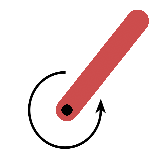


Not a stable state - only rotation
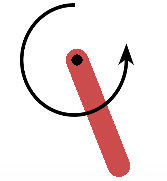

## Result:

100 training iterations are not enough at all to achieve the goal of the game. The pendulum does not reach a stable state and remains constantly rotating.
The model has learned something anyway. The average reward that is achieved after each game is fairly stable at around -7. Which is a little better than the middle between the highest and the lowest possible reward.

## Perfomance after 1000 trainings iterations
0 sequence. Average reward for games played = -1.052063390848371 Average test reward for the last game = -1.052063390848371

1 sequence. Average reward for games played = -1.06331974613138 Average test reward for the last game = -1.0745761014143884

2 sequence. Average reward for games played = -0.8811775233321392 Average test reward for the last game = -0.5168930777336576

3 sequence. Average reward for games played = -0.9199713812756705 Average test reward for the last game = -1.036352955106264

4 sequence. Average reward for games played = -1.0512135051080655 Average test reward for the last game = -1.5761820004376468

5 sequence. Average reward for games played = -1.1080562257642872 Average test reward for the last game = -1.3922698290453939

6 sequence. Average reward for games played = -0.9511586114339524 Average test reward for the last game = -0.00977292545194454

7 sequence. Average reward for games played = -0.9581994154025456 Average test reward for the last game = -1.0074850431826992

8 sequence. Average reward for games played = -0.9060785008870038 Average test reward for the last game = -0.4891111847626694

9 sequence. Average reward for games played = -0.8677362276085312 Average test reward for the last game = -0.5226557681022787

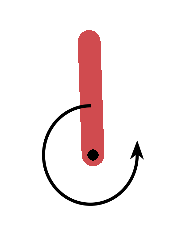

## Result

After 1000 iterations, the model already shows good results. The joint manages to reach the vertical state in every game and then remains in this state. 

The stable actions pair (the joint effort) is 1.789473684210526 -1.7894736842105263. It is relatively close to the highest effort of 2/-2

The average reward that is achieved after each game is fairly stable at around -1. What is already relatively close to the highest possible reward.

## Perfomance after 10000(!) trainings iterations

0  sequence. Average reward for games played =  -0.5232625098407498 
       Average test reward for the last game =  -0.5232625098407498 

1  sequence. Average reward for games played =  -0.5233095390471187 
       Average test reward for the last game =  -0.5233565682534876 

2  sequence. Average reward for games played =  -0.5181041380587004 
       Average test reward for the last game =  -0.5076933360818638 

3  sequence. Average reward for games played =  -0.6864497010470784 
       Average test reward for the last game =  -1.1914863900122126 

4  sequence. Average reward for games played =  -0.8656399889687476 
       Average test reward for the last game =  -1.5824011406554248 

5  sequence. Average reward for games played =  -0.7228553443584218 
       Average test reward for the last game =  -0.008932121306791965 

6  sequence. Average reward for games played =  -0.6212540369958945 
       Average test reward for the last game =  -0.011646192820732239 

7  sequence. Average reward for games played =  -0.7315780448734915 
       Average test reward for the last game =  -1.50384610001667 

8  sequence. Average reward for games played =  -0.7082296752429788 
       Average test reward for the last game =  -0.521442718198876 

9  sequence. Average reward for games played =  -0.6375586279941049 
       Average test reward for the last game =  -0.001519202754240565

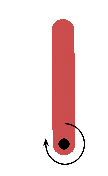

## Result
After 10000 iterations, the model shows very good results. 
The joint immediately reaches the vertical state in every game and then remains in this state. 

The stable actions pair (the joint effort) is 0.736842105263158 -0.736842105263158. This is much better than the "1000 iteration model". 

The average reward that is achieved after each game is in the range between 0 and 1. What almost strives against the highest possible reward.

# Experimet results with 10 action bins

## Perfomance after 1000 trainings iterations
0  sequence. Average reward for games played =  -0.011497675814314504 
       Average test reward for the last game =  -0.011497675814314504 

1  sequence. Average reward for games played =  -0.2756282013902501 
       Average test reward for the last game =  -0.5397587269661858 

2  sequence. Average reward for games played =  -0.18624293541398457 
       Average test reward for the last game =  -0.007472403461453355 

3  sequence. Average reward for games played =  -0.2775928365145627 
       Average test reward for the last game =  -0.551642539816297 

4  sequence. Average reward for games played =  -0.43594615209139054 
       Average test reward for the last game =  -1.069359414398702 

5  sequence. Average reward for games played =  -0.5285994347552176 
       Average test reward for the last game =  -0.9918658480743527 

6  sequence. Average reward for games played =  -0.45504856171823904 
       Average test reward for the last game =  -0.013743323496367954 

7  sequence. Average reward for games played =  -0.46286881520727485 
       Average test reward for the last game =  -0.5176105896305259 

8  sequence. Average reward for games played =  -0.4672808748859912 
       Average test reward for the last game =  -0.5025773523157215 

9  sequence. Average reward for games played =  -1.0167289487681967 
       Average test reward for the last game =  -5.961761613708048 

10  sequence. Average reward for games played =  -0.9708180082176158 
       Average test reward for the last game =  -0.5117086027118061 

11  sequence. Average reward for games played =  -1.0161897133860798 
       Average test reward for the last game =  -1.515278470239184 

12  sequence. Average reward for games played =  -1.0161319433501477 
       Average test reward for the last game =  -1.0154387029189622 

13  sequence. Average reward for games played =  -1.4765677540309614 
       Average test reward for the last game =  -7.4622332928815425 

14  sequence. Average reward for games played =  -1.4486245691731698 
       Average test reward for the last game =  -1.0574199811640879 

15  sequence. Average reward for games played =  -1.432035965341468 
       Average test reward for the last game =  -1.1832069078659357 

16  sequence. Average reward for games played =  -1.3759436508417455 
       Average test reward for the last game =  -0.47846661884618413 

17  sequence. Average reward for games played =  -1.3000447121418721 
       Average test reward for the last game =  -0.009762754244029217 

18  sequence. Average reward for games played =  -1.2830970252729572 
       Average test reward for the last game =  -0.978038661632483 

19  sequence. Average reward for games played =  -1.2688661232225709 
       Average test reward for the last game =  -0.9984789842652324 

## Results

This joint has chosen a very interesting strategy. Instead of supporting the pendulum evenly in the vertical state from both sides, it keeps it in a slightly slanting state with relatively little effort.

The sequence of actions in the stable state of the pendulum ist:-0.6666666666666667 -0.22222222222222232 -0.22222222222222232. Indeed, this is the minimal effort after all experiments! But the position of the pendulum was more precise in the case of 20 action bin.
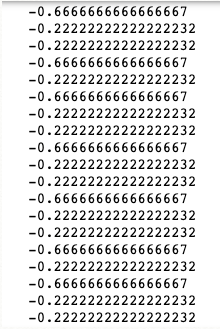

The average reward that is achieved after each game is around -1, but has much greater fluctuations than when training with 20 action bins.


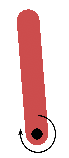

# Experimet results with 40 action bins
## Perfomance after 1000 trainings iterations

0  sequence. Average reward for games played =  -5.997248798243338 
       Average test reward for the last game =  -5.997248798243338 

1  sequence. Average reward for games played =  -6.0378953326957925 
       Average test reward for the last game =  -6.078541867148248 

2  sequence. Average reward for games played =  -4.029153225207264 
       Average test reward for the last game =  -0.011669010230207623 

3  sequence. Average reward for games played =  -3.289661010695221 
       Average test reward for the last game =  -1.0711843671590908 

4  sequence. Average reward for games played =  -3.8556474937105194 
       Average test reward for the last game =  -6.119593425771716 

5  sequence. Average reward for games played =  -3.2148397992556244 
       Average test reward for the last game =  -0.010801326981149627 

6  sequence. Average reward for games played =  -2.906169987456359 
       Average test reward for the last game =  -1.0541511166607682 

7  sequence. Average reward for games played =  -3.283352299730611 
       Average test reward for the last game =  -5.9236284856503705 

8  sequence. Average reward for games played =  -2.978608286012078 
       Average test reward for the last game =  -0.5406561762638122 

9  sequence. Average reward for games played =  -2.6827174533191847 
       Average test reward for the last game =  -0.019699959083148783 

10  sequence. Average reward for games played =  -3.007397024429498 
       Average test reward for the last game =  -6.254192735532634 

11  sequence. Average reward for games played =  -3.2629629137319918 
       Average test reward for the last game =  -6.074187696059414 

12  sequence. Average reward for games played =  -3.013436953146888 
       Average test reward for the last game =  -0.01912542612564761 

13  sequence. Average reward for games played =  -2.8358434016472214 
       Average test reward for the last game =  -0.5271272321515574 

14  sequence. Average reward for games played =  -3.0533215349118086 
       Average test reward for the last game =  -6.098015400616023 

15  sequence. Average reward for games played =  -2.863781218881719 
       Average test reward for the last game =  -0.020676478430379206 

16  sequence. Average reward for games played =  -3.07208698222957 
       Average test reward for the last game =  -6.404979195795198 

17  sequence. Average reward for games played =  -2.9571527512334086 
       Average test reward for the last game =  -1.003270824298664 

18  sequence. Average reward for games played =  -3.134066300848912 
       Average test reward for the last game =  -6.318510193927961 

19  sequence. Average reward for games played =  -3.2761281391172976 
       Average test reward for the last game =  -5.975303066216628 

## Results

The model is clearly undertrained for this number of classes (40). The joint hardly finds its stable condition.
Every now and then it comes to this actions sequence and can then hold the pendulum:
-2.0
-0.6666666666666667
-0.6666666666666667
-0.6666666666666667
1.8974358974358974
But it happens rather sporadically.


It has not had enough experience to choose the best action for each state. Training with at least 10,000 iterations would make more sense for this number of classes.


## Summary

Both the number of classes/action bins and the number of iterations play a significant role in the training effect. During 10000 iterations, the model behaves like an adult who, based on his experience, goes straight to his goal. An undertrained model "plays" with his surroundings like a child.

## Next steps to take it from here

- Implement a skip frame approach
- Experiment with the discretization of the action bins (e.g. advantages and disadvantages of triadisation)
- Experiment with exploration vs exploitation

Send extended ipynb file to mark.schutera@kit.edu for the chance to get bonus points for the final project.